In [1]:
from astropy.io import fits
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import processing_functions as pf
import scipy.stats as stats
import scipy.special as sps
import scipy.optimize as opt
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [19]:
hdu = fits.open('/home/ravioli/astro/ksp/grb/GRB160909A/AS1G05_102T01_9000000650_05136cztM0_level2_bc_livetime.fits')
hdu[4].header['LV_BINSIZE'] = 1.0
hdu.writeto('/home/ravioli/astro/ksp/grb/GRB160909A/AS1G05_102T01_9000000650_05136cztM0_level2_bc_livetime.fits',overwrite=True)

In [23]:
for i in range(5):
    print(fits.open("/home/ravioli/astro/ksp/grb/GRB160909A/AS1G05_102T01_9000000650_05136cztM0_level2_bc_livetime.fits")[i].header['LV_BINSIZE'])

1.0
1.0
1.0
1.0
1.0


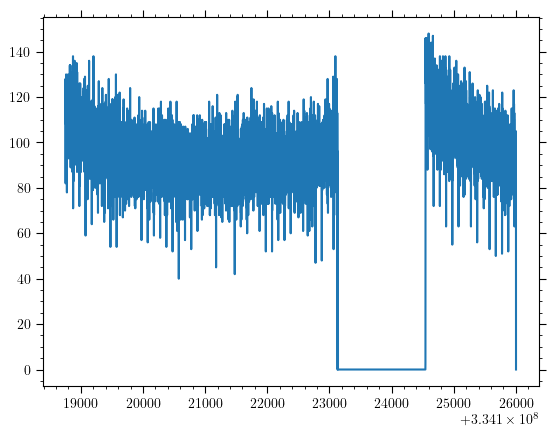

In [2]:
daat = fits.getdata("/home/ravioli/astro/ksp/grb/GRB200803A/AS1C05_019T04_9000003788_26214cztM0_level2_quad_clean_Q1.lc")
plt.plot(daat['TIME'],daat['RATE'])